<font size = 6> Credit Card Fraud Prediction <font>

<font size = 5> **About Data** <font>

The dataset contains transactions made by credit cards in September 2013 by European cardholders.

I downloaded the dataset from Kaggle: <br>
https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud?datasetId=310&sortBy=voteCount

This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

<font size = 5> **Load Packages** <font>

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score

<font size = 5> **Read Data** <font>

In [2]:
cc  = pd.read_csv("creditcard.csv")
cc.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
#convert time column to hours
cc["Time"] = (cc["Time"]/3600).round()

#Dataset size
cc.shape

(284807, 31)

<font size = 5> **Any null values?** <font>

In [4]:
cc.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

<font size = 5> **Data Visualization** <font>

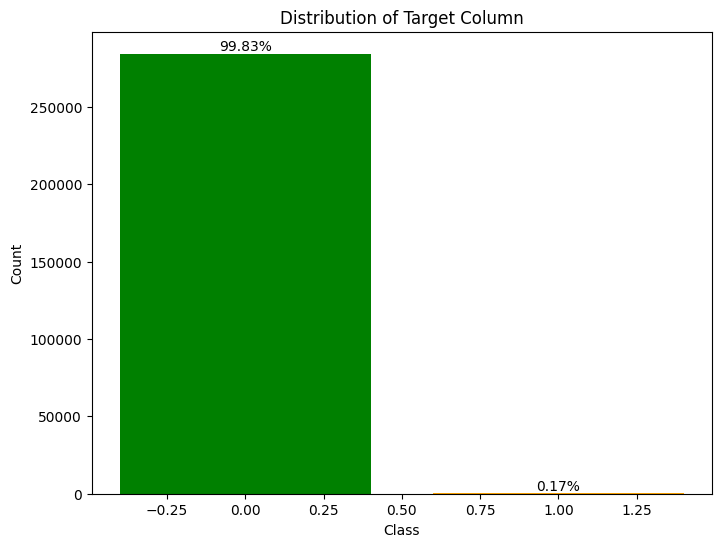

In [5]:
#counts for each class
class_counts = cc["Class"].value_counts()
class_percentage = class_counts * 100 / class_counts.sum()
#plot a bar plot showing the unbalanced target values
plt.figure(figsize=(8, 6))
bars = plt.bar(class_counts.index, class_counts, color = ["green", "orange"])
plt.title('Distribution of Target Column')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=0)  
for bar, percentage in zip(bars, class_percentage):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, f'{percentage:.2f}%', ha='center', va='bottom')

plt.show()

**Note:** <br>
We observe that the target column is highly unbalanced and only 0.17% of the transactions are fraudulent.

<font size = 5> Distribution of the Amount column based on the Class <font>

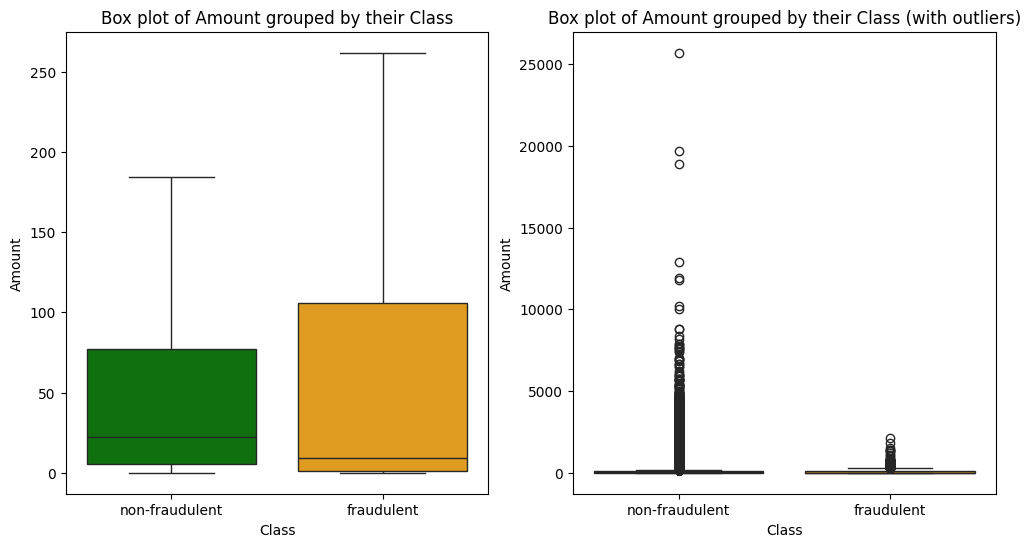

In [6]:
# Create a figure and axes with subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

#First subplot: Box plot without outliers
sns.boxplot(x = "Class", y = "Amount", data = cc, 
            hue = "Class", palette = ["green", "orange"], 
            showfliers = False, ax = axes[0], legend = False)

#set title
axes[0].set_title("Box plot of Amount grouped by their Class")

#set x labels
axes[0].set_xticks([0, 1])
axes[0].set_xticklabels(["non-fraudulent", "fraudulent"])


# Second subplot: Box plot with outliers
sns.boxplot(x = "Class", y = "Amount", data = cc, 
            hue = "Class", palette = ["green", "orange"], 
            showfliers = True, ax = axes[1], legend = False)

#set title
axes[1].set_title("Box plot of Amount grouped by their Class (with outliers)")
#set x labels
axes[1].set_xticks([0, 1])
axes[1].set_xticklabels(["non-fraudulent", "fraudulent"])
plt.show()


**Note:** <br>
In the box plot, we see that big transactions are more common in non-fraudulent cases. However, fraudulent transactions show a wider range of amounts. The 3rd quartile of fraudulent transactions goes higher than in non-fraudulent ones, while the ast quartile is lower. This suggests fraud involves both smaller and larger amounts. Overall, fraud covers a wider range of transaction sizes compared to non-fraudulent activities.nts.

In [7]:
cc.groupby("Class").agg({
    "Amount": ["max", "mean", "median"],
    "Time": ["max", "mean", "median"]
})

Amount                     Time                  
            max        mean median   max       mean median
Class                                                     
0      25691.16   88.291022  22.00  48.0  26.342493   24.0
1       2125.87  122.211321   9.25  47.0  22.404472   21.0

Text(0.5, 0, 'Time(hours)')

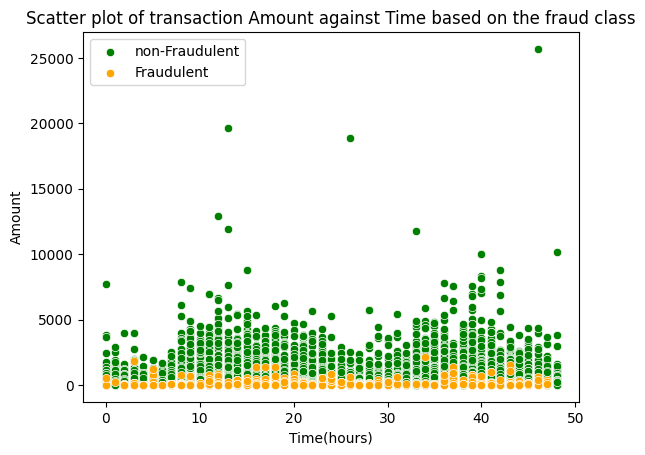

In [8]:
#scatterplot of Amount of transactions against Time
sns.scatterplot(x = "Time", y = "Amount", data = cc[cc["Class"] == 0], color = "green", alpha = 1, label = "non-Fraudulent")
sns.scatterplot(x = "Time", y = "Amount", data = cc[cc["Class"] == 1], color = "orange", alpha = 1, label = "Fraudulent")


#The majority of transactions are below 10000 so for a better visualization we will limit the Amount up to 10000
plt.title("Scatter plot of transaction Amount against Time based on the fraud class")
plt.xlabel("Time(hours)")

In [9]:
#group data by time and get the mean amount of transactions for each hour
grouped_cc = cc.groupby(["Time", "Class"]).agg("mean").reset_index()
grouped_cc.tail()

,Time,Class,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
92,46.0,0,0.258523,0.151816,-0.725678,-0.180652,0.282204,-0.120972,0.135953,-0.015506,...,-0.038539,-0.002464,0.059786,0.031704,-0.039252,-0.150710,-0.016131,0.008406,-0.014405,71.492332
93,46.0,1,-2.589476,-0.916226,-2.269938,2.356680,1.755565,-1.021750,-1.800281,-2.934023,...,0.488402,-0.988859,0.791873,0.800880,0.377923,-0.430474,-0.091836,0.501606,0.185705,175.923333
94,47.0,0,0.116145,0.297744,-0.784340,-0.158825,0.323497,-0.120397,0.117772,0.019991,...,-0.015128,0.010273,0.087322,0.039068,0.001541,-0.148760,0.004619,-0.004703,-0.006681,66.831430
95,47.0,1,-0.469465,0.857148,-3.943890,1.171043,-0.386784,-1.276124,-1.303142,0.629249,...,0.403138,0.463989,-0.004238,0.031288,-0.195557,0.060956,0.463094,0.390960,0.051991,151.236000
96,48.0,0,0.031996,0.398993,-0.774511,-0.150690,0.280369,-0.159726,0.144012,0.038431,...,-0.010479,-0.002669,0.073834,0.048358,0.017057,-0.139766,-0.010753,0.005152,-0.004295,65.039847


<font size = 5> Mean Amount over time based on the class<font>

Text(0.5, 1.0, 'Line plot of average transaction amount in in different hours based on the class')

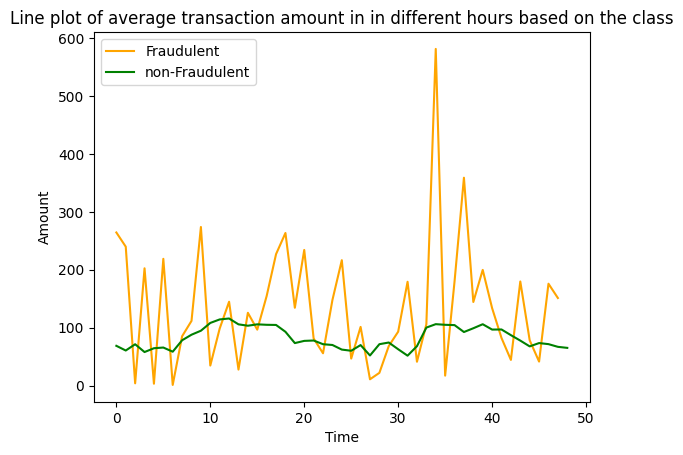

In [10]:
sns.lineplot(x = "Time",  y = "Amount", data = grouped_cc[grouped_cc["Class"] == 1], label = "Fraudulent", color = "orange")
sns.lineplot(x = "Time",  y = "Amount", data = grouped_cc[grouped_cc["Class"] == 0], label = "non-Fraudulent", color = "green")
plt.title("Line plot of average transaction amount in in different hours based on the class")

**Note:** <br>
The average transaction amount remains relatively stable over time for non-fraudulent transactions, indicating consistency in spending patterns. In contrast, for fraudulent transactions, the average transaction amount exhibits greater variability, suggesting fluctuations in the amounts involved. This instability in transaction amounts for fraudulent activities reflects the dynamic nature of fraudulent behavior, which may involve irregular spending patterns and varying transaction sizes.

<font size = 5> **Correlation between features and target** <font>

<Axes: >

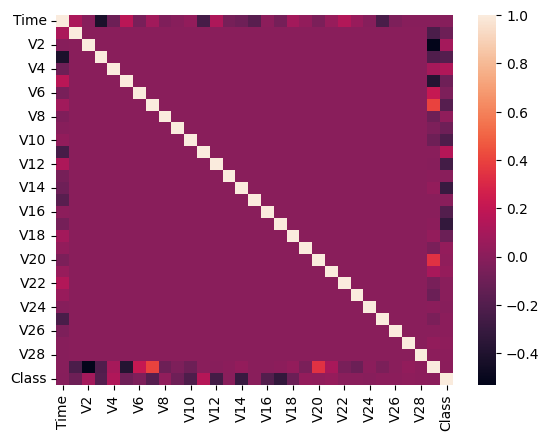

In [11]:
sns.heatmap(cc.corr())

As we expected since the features V2, V4, ... are the principal components obtained with PCA, they do not have any correlation with each other. <br>
The only correlation is between Time, Class with other features.

In [12]:
cc.drop(columns = ["Class"])

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69
2,0.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66
3,0.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50
4,0.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,48.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,1.475829,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77
284803,48.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.059616,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79
284804,48.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.001396,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88
284805,48.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.127434,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00


<font size = 5> **Split data into train and test sets with 70/30 proportion** <font>

In [13]:
y = cc["Class"].astype(str)
x = cc.drop(columns = ["Class"])

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 22)

In [14]:
print(100 * (y_train == "1").mean())
print(100 * (y_test == "1").mean())

0.17254870488152324
0.17321489179921118


Fraudulent transactions are distributed between the train and test sets equally, however they are both unbalanced and we have to do something about it.

<font size = 5> **Logistic Regression Model** <font>

In [15]:
#create model
logistic_model = LogisticRegression(max_iter = 1000)

#fit the model
logistic_model.fit(x_train, y_train)

#predict test set(threshold 0.5)
y_pred = logistic_model.predict(x_test)

#predict test set probabilities
y_pred_prob = logistic_model.predict_proba(x_test)[:,1]

<font size = 5 >ROC Curve, Accuracy and Confusion Matrix: <font>

In [16]:
# Calculate accuracy
accuracy1 = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy1:.4f}')

# Calculate AUC
auc_score1 = roc_auc_score(y_test, y_pred_prob)
print(f'AUC: {auc_score1:.4f}')

Accuracy: 0.9992
AUC: 0.9830


It looks like model was able to predict correctly more than 99.9% of the time, however since the data was extremely imbalanced, we cannot trust this number and have to check the sensitivity and specificity.

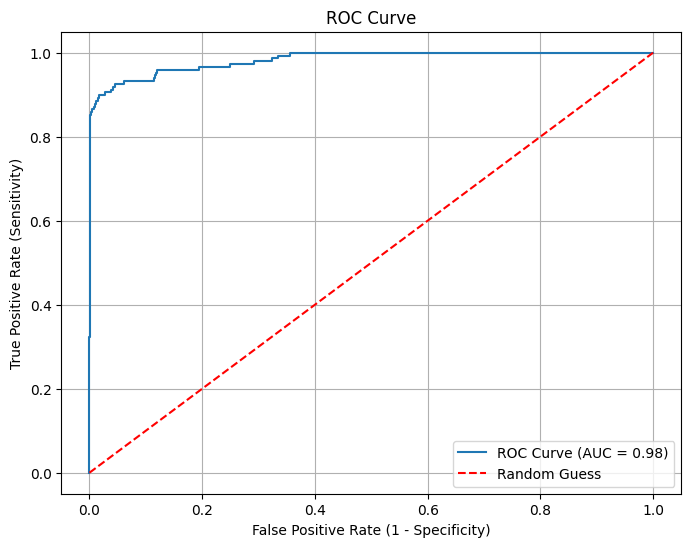

In [17]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob, pos_label = "1" )

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score1:.2f})')
plt.plot([0, 1], [0, 1], 'r--', label='Random Guess')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

**Specificity and Sensitivity**

In [18]:
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
print(f'Sensitivity: {sensitivity:.4f}')
print(f'Specificity: {specificity:.4f}')

Sensitivity: 0.6284
Specificity: 0.9998


**Note:** <br>
As we see the model is performing very well in predicting the non-fraudulent cases **(specificity = 0.9998)** and that is because they are the majority of the data. <br>
However, the model is not performing well on predicting the fraudulent cases **(sensitivity = 0.6283)**. We need to define penalties for predicting the fraudulent cases wrong so the model would do better in predicting those cases.

<font size = 5> **Penalize the misclassification of the minority class**<font>

In [19]:
#create model
logistic_model = LogisticRegression(max_iter = 10000, class_weight = "balanced")

#fit the model
logistic_model.fit(x_train, y_train)

#predict test set
y_pred = logistic_model.predict(x_test)

#predict test set probabilities
y_pred_prob = logistic_model.predict_proba(x_test)[:, 1]

In [20]:
# Calculate accuracy
accuracy2 = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy2:.4f}')

# Calculate AUC
auc_score2 = roc_auc_score(y_test, y_pred_prob)
print(f'AUC: {auc_score2:.4f}')

Accuracy: 0.9772
AUC: 0.9846


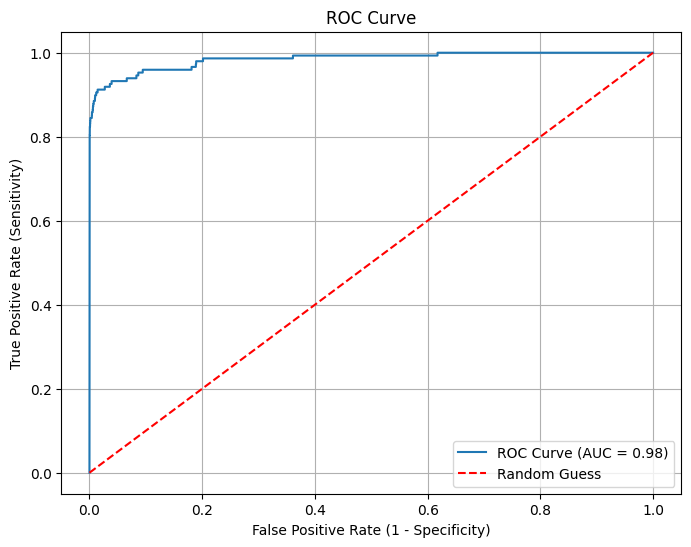

In [21]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob, pos_label = "1" )

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score2:.2f})')
plt.plot([0, 1], [0, 1], 'r--', label='Random Guess')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

**Specificity and Sensitivity**

In [22]:
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
print(f'Sensitivity: {sensitivity:.4f}')
print(f'Specificity: {specificity:.4f}')

Sensitivity: 0.9122
Specificity: 0.9773


**Note:** <br>
We can see that after penalizing the model for misclassifying the minority class, number of negative cases predicted incorrectly increased a little **(specificity = 0.97)**, in return number of positive cases that were predicted correctly increased a lot. **(sensitivity = 0.91)**

In [23]:
coefficients = np.abs(logistic_model.coef_[0])
feature_names = x_train.columns
variable_importance = pd.DataFrame({"features":feature_names, "coefficients": coefficients})
variable_importance = variable_importance.sort_values(by = "coefficients", ascending = False)

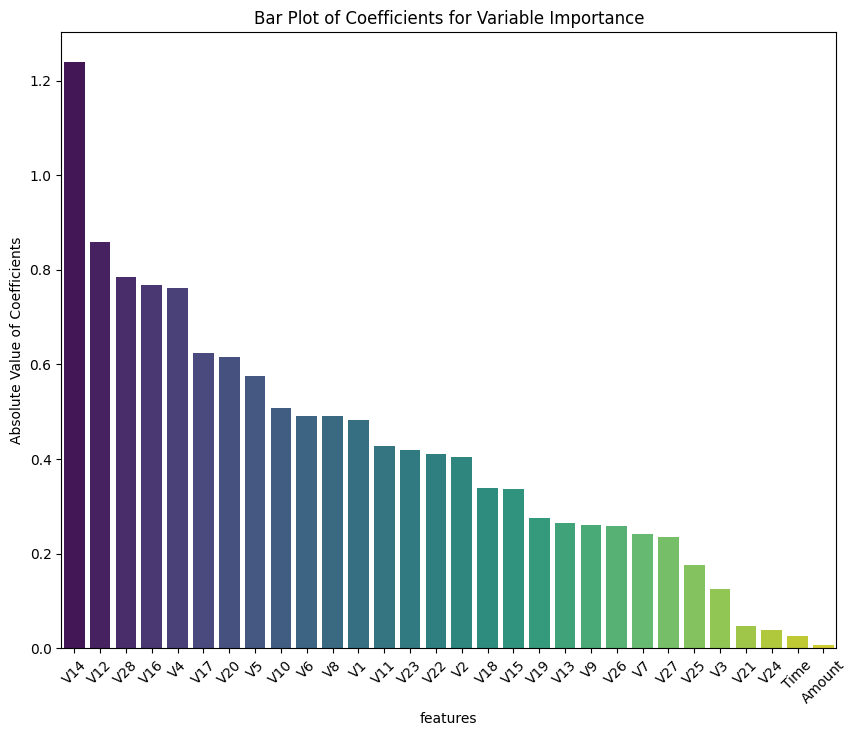

In [24]:
plt.figure(figsize = (10, 8))
sns.barplot(x = "features", y = "coefficients", data = variable_importance, hue = "features", palette = "viridis")
plt.title("Bar Plot of Coefficients for Variable Importance")
plt.ylabel("Absolute Value of Coefficients")
plt.xticks(rotation = 45)
plt.show()

Looking at the absolute values of the coefficients, we observe that V14, V12, V28, V16, and V4 have greater significance in predicting the fraudulent status of transactions. As these variables are derived from Principal Component Analysis (PCA), their interpretation is challenging, but we can still visualize their distribution. Notably, Time and Amount do not play significant roles in predicting transaction fraudulence. This aligns with our earlier observations from the plots, where Time and Amount exhibited random patterns.

[Text(0, 0, 'non-fraudulent'), Text(1, 0, 'fraudulent')]

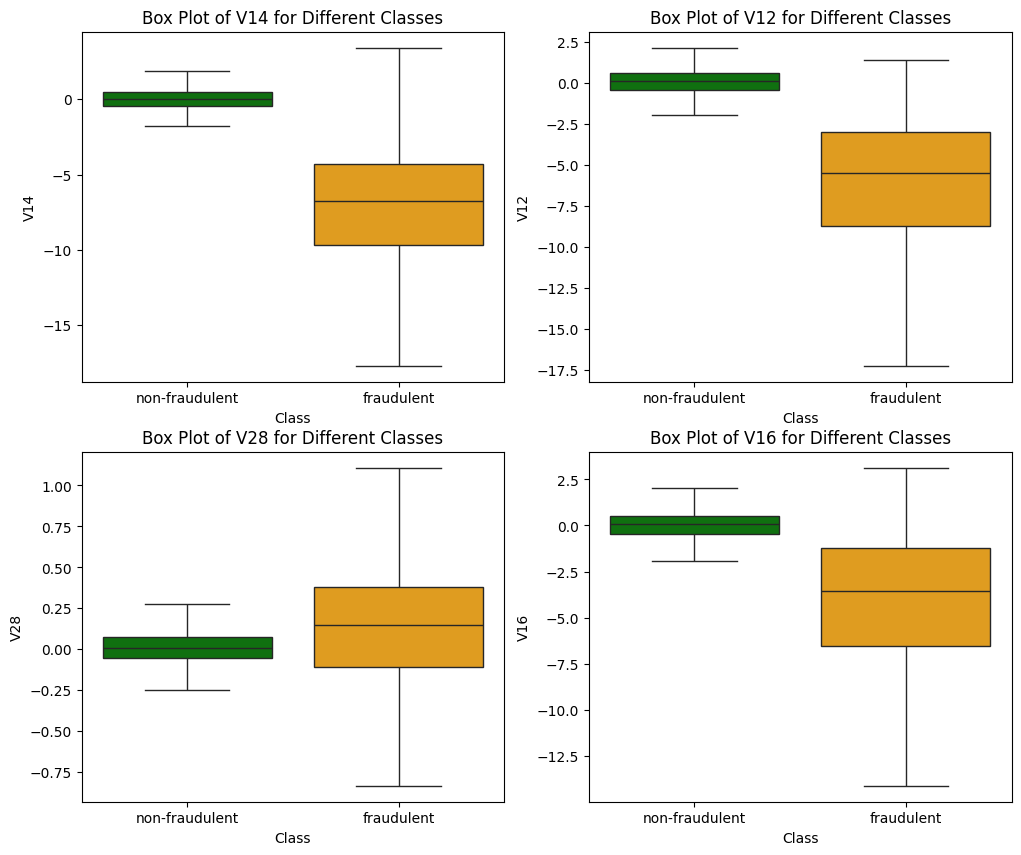

In [25]:
fig, axes = plt.subplots(2, 2, figsize = (12, 10))

#create first plot
sns.boxplot(x = "Class", y = "V14", data = cc, 
            hue = "Class", palette = ["green", "orange"], 
            showfliers = False,
           legend = False, ax = axes[0, 0])
axes[0, 0].set_title("Box Plot of V14 for Different Classes")
axes[0, 0].set_xticks([0, 1])
axes[0, 0].set_xticklabels(["non-fraudulent", "fraudulent"])

#create 2nd plot
sns.boxplot(x = "Class", y = "V12", data = cc, 
            hue = "Class", palette = ["green", "orange"], 
            showfliers = False,
           legend = False, ax = axes[0, 1])
axes[0, 1].set_title("Box Plot of V12 for Different Classes")
axes[0, 1].set_xticks([0, 1])
axes[0, 1].set_xticklabels(["non-fraudulent", "fraudulent"])


#create 3rd plot
sns.boxplot(x = "Class", y = "V28", data = cc,
            hue = "Class", palette = ["green", "orange"],
            showfliers = False,
            legend = False, ax = axes[1, 0])
axes[1, 0].set_title("Box Plot of V28 for Different Classes")
axes[1, 0].set_xticks([0, 1])
axes[1, 0].set_xticklabels(["non-fraudulent", "fraudulent"])


#create 4th plot
sns.boxplot(x = "Class", y = "V16", data = cc,
            hue = "Class", palette = ["green", "orange"],
            showfliers = False,
            legend = False, ax = axes[1, 1])
axes[1, 1].set_title("Box Plot of V16 for Different Classes")
axes[1, 1].set_xticks([0, 1])
axes[1, 1].set_xticklabels(["non-fraudulent", "fraudulent"])

**Note:** <br>
The box plots for features V14, V12, and V16 show that non-fraudulent and fraudulent transactions have different distributions. This suggests that these features could be good predictors for the Class variable. Meanwhile, feature V28 has similar average values for both classes, but the fraudulent transactions seem to spread out more.

<font size = 5> **Cross Validation** <font>

Since the fraudulent transactions are not that many in our dataset, it is good to use cross validation for fitting the model

In [26]:
logistic_model_cv = LogisticRegression(max_iter = 10000, class_weight = "balanced")
skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 22)

y_pred = cross_val_predict(logistic_model_cv, x, y, cv = skf)
y_pred_prob = cross_val_predict(logistic_model_cv, x, y, cv = skf, method = "predict_proba")[:, 1]

In [27]:
accuracy3 = accuracy_score(y, y_pred)
print(f'Accuracy: {accuracy3:.4f}')

auc_score3 = roc_auc_score(y, y_pred_prob)
print(f'AUC: {auc_score3:.4f}')

Accuracy: 0.9770
AUC: 0.9768


cross validation using stratifiedkfold is a good option for imbalanced data ensuring that each fold maintains the same class distribution as the entire dataset. 